In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re, os, string

%matplotlib inline

## Loading Data

In [2]:
train = pd.read_csv('../dataset/train_cleaned.csv')
test = pd.read_csv('../dataset/test_cleaned.csv')

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5200 non-null   int64  
 1   title           5077 non-null   object 
 2   author          4697 non-null   object 
 3   text            5193 non-null   object 
 4   original_text   5193 non-null   object 
 5   text_words      5200 non-null   object 
 6   text_digit_cnt  5200 non-null   int64  
 7   clean_text_lem  5200 non-null   object 
 8   clean_text      5200 non-null   object 
 9   title_polarity  5200 non-null   float64
 10  text_polarity   5200 non-null   float64
 11  ttl_wrds        5200 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 487.6+ KB


In [4]:
## Dropping the 0 variance column and id
test_id = test.id
train.drop(['title_polarity','id'],axis=1,inplace= True)
test.drop(['title_polarity','id'],axis=1,inplace= True)

In [5]:
## Replacing null values with empty string to treat them as str and not float
test=test.fillna(' ')
train=train.fillna(' ')

In [7]:
## Checking id count in test dataset
len(test_id)

5200

In [8]:
## Getting column names from dataset

# all columns
cols = train.columns

# only numeric columns
cols_num = train.select_dtypes([np.number]).columns

# only string columns
cols_str = train.select_dtypes(object).columns

print(cols)
print(cols_num)
print(cols_str)

Index(['title', 'author', 'text', 'label', 'original_text', 'text_words',
       'text_digit_cnt', 'clean_text_lem', 'clean_text', 'text_polarity',
       'ttl_wrds'],
      dtype='object')
Index(['label', 'text_digit_cnt', 'text_polarity', 'ttl_wrds'], dtype='object')
Index(['title', 'author', 'text', 'original_text', 'text_words',
       'clean_text_lem', 'clean_text'],
      dtype='object')


## Data Preparation

In [9]:
## Combing text data for vectorization
all_text = pd.concat([train[cols_str],test[cols_str]])
all_text.head()

,title,author,text,original_text,text_words,clean_text_lem,clean_text
0,house dem aide we didn’t even see comey’s lett...,darrell lucus,house dem aide we didn’t even see comey’s lett...,House Dem Aide: We Didn’t Even See Comey’s Let...,"['house', 'dem', 'aide', 'we', 'didn', '’', 't...","['house', 'dem', 'aide', 'we', 'didn', '’', 't...","['house', 'dem', 'aide', '’', 'even', 'see', '..."
1,flynn hillary clinton big woman on campus bre...,daniel j flynn,ever get the feeling your life circles the rou...,Ever get the feeling your life circles the rou...,"['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'get', 'feeling', 'life', 'circle', '..."
2,why the truth might get you fired,consortiumnewscom,why the truth might get you fired october \n...,"Why the Truth Might Get You Fired October 29, ...","['why', 'the', 'truth', 'might', 'get', 'you',...","['why', 'the', 'truth', 'might', 'get', 'you',...","['truth', 'might', 'get', 'fired', 'october', ..."
3,civilians killed in single us airstrike have ...,jessica purkiss,videos civilians killed in single us airstrik...,Videos 15 Civilians Killed In Single US Airstr...,"['videos', 'civilians', 'killed', 'in', 'singl...","['video', 'civilian', 'killed', 'in', 'single'...","['video', 'civilian', 'killed', 'single', 'u',..."
4,iranian woman jailed for fictional unpublished...,howard portnoy,print \nan iranian woman has been sentenced to...,Print \nAn Iranian woman has been sentenced to...,"['print', 'an', 'iranian', 'woman', 'has', 'be...","['print', 'an', 'iranian', 'woman', 'ha', 'bee...","['print', 'iranian', 'woman', 'ha', 'sentenced..."


### Train data preparation

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_transformer =  TfidfVectorizer(stop_words='english', use_idf=True, min_df=0.05, ngram_range=(1,2))
text_transformer.fit(all_text.title + all_text.text)

## more reptitions in authors - do not ignore the 5% data,keeping the uniques value
author_transformer =  TfidfVectorizer(stop_words='english', use_idf=True, ngram_range=(1,2))
author_transformer.fit(all_text.author)

TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

In [11]:
## Transforming the train data for text, title and author
title_text_tfidf = text_transformer.transform(train.title + train.text)
author_tfidf = author_transformer.transform(train.author)

In [12]:
## Transforming the numeric columns using minmax scaler
from sklearn.preprocessing import MinMaxScaler

train_num = pd.DataFrame(MinMaxScaler().fit_transform(train[cols_num[1:]]),columns =cols_num[1:] )

In [13]:
## Combining the columns to create the training dataset
import scipy.sparse
train_prep = scipy.sparse.hstack([title_text_tfidf,author_tfidf,train_num])
train_prep.shape

(20800, 10887)

### Train data preparation

In [14]:
## Applying same tranformations to create the test dataset
test_title_text_tfidf = text_transformer.transform(test.title + test.text)
test_author_tfidf = author_transformer.transform(test.author)
test_num= pd.DataFrame(MinMaxScaler().fit_transform(test[cols_num[1:]]),columns =cols_num[1:] )

test_prep = scipy.sparse.hstack([test_title_text_tfidf,test_author_tfidf,test_num])
test_prep.shape

(5200, 10887)

## Creating train test split for cross validation

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_prep, train.label, test_size= 0.25 ,random_state=42)

## Accuracy functions

In [16]:
## Used in below models for cross validation accuracy
from sklearn.metrics import confusion_matrix, f1_score,precision_score,recall_score

def accuracy (act,pred):
    print('Confusion Matrix:\n',confusion_matrix(act,pred))
    print('Precision score: {:.4f}'.format(precision_score(act,pred)))
    print('Recall score: {:.4f}'.format(recall_score(act,pred)))
    print('F1 score: {:.4f}'.format(f1_score(act,pred)))

In [17]:
## Used in below models to visualize the precision recall tradeoff and auc score and roc curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid()
    plt.legend()
    plt.xlabel('Threshold')
    plt.show()

def plot_roc_curve (fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Posiitve Rate")
    plt.show()

def plot_prt_roc(tr,scores):
    precisions,recalls,thresholds = precision_recall_curve(tr,scores)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    fpr, tpr, threshold = roc_curve(tr,scores)
    plot_roc_curve(fpr,tpr)
    plt.show()  

## Model Building and Testing

### Model 1: Stochastic Gradient Descent Classifier

[0.9875     0.98846154 0.9900641  0.98173077 0.98910256]
Confusion Matrix:
 [[2605   37]
 [  30 2528]]
Precision score: 0.9856
Recall score: 0.9883
F1 score: 0.9869


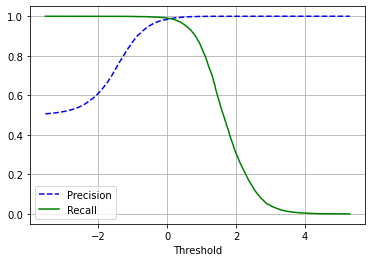

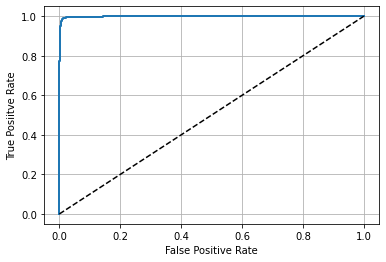

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

sgd_clf = SGDClassifier(random_state =42)

## Fitting the model
sgd_clf.fit(X_train,y_train)
print(cross_val_score(sgd_clf,X_train,y_train,cv=5,scoring="accuracy"))

## Predicting on the test set
sgd_pred = sgd_clf.predict(X_test)

## Checking accuracy metrics by function defined above
accuracy(y_test,sgd_pred)

## PLotting the AUC ROC Curve and Precision vs Recall Curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=5,method="decision_function")
plot_prt_roc(y_train,y_scores)

#### Training the model on entire train set and saving the model

In [19]:
import pickle

sgd_clf.fit(train_prep,train.label)
pickle.dump(sgd_clf, open('../models/sgd_clf.sav', 'wb'))

### Model 2: Logistic Regression

[0.98044872 0.97980769 0.98397436 0.975      0.98044872]
Confusion Matrix:
 [[2598   44]
 [  49 2509]]
Precision score: 0.9828
Recall score: 0.9808
F1 score: 0.9818


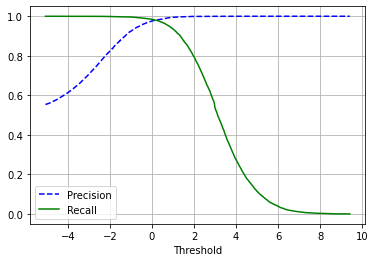

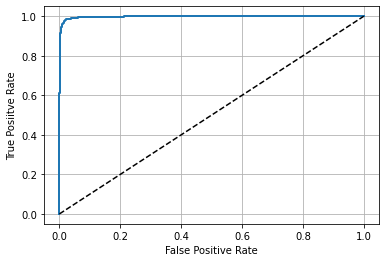

In [20]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state =42)

## Fitting the model
log_clf.fit(X_train,y_train)
print(cross_val_score(log_clf,X_train,y_train,cv=5,scoring="accuracy"))

## Predicting on the test set
log_pred = log_clf.predict(X_test)

## Checking accuracy metrics by function defined above
accuracy(y_test,log_pred)

## PLotting the AUC ROC Curve and Precision vs Recall Curve
y_scores = cross_val_predict(log_clf, X_train, y_train, cv=5,method="decision_function")
plot_prt_roc(y_train,y_scores)

#### Training the model on entire train set and saving the model

In [21]:
log_clf.fit(train_prep,train.label)
pickle.dump(log_clf, open('../models/log_clf.sav', 'wb'))

### Model 3: Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

## Fitting the model
rf_clf = RandomForestClassifier(random_state =42)
rf_clf.fit(X_train,y_train)
print(cross_val_score(rf_clf,X_train,y_train,cv=5,scoring="accuracy"))

## Predicting on the test set
rf_pred = rf_clf.predict(X_test)

## Checking accuracy metrics by function defined above
accuracy(y_test,rf_pred)


[0.94807692 0.94871795 0.94230769 0.94775641 0.94391026]
Confusion Matrix:
 [[2528  114]
 [ 164 2394]]
Precision score: 0.9545
Recall score: 0.9359
F1 score: 0.9451


#### Training the model on entire train set and saving the model

In [3]:
rf_clf.fit(train_prep,train.label)
pickle.dump(log_clf, open('../models/rf_clf.sav', 'wb'))

### Model 4: SVC

[0.98878205 0.99166667 0.99134615 0.98589744 0.99038462]
Confusion Matrix:
 [[2614   28]
 [  24 2534]]
Precision score: 0.9891
Recall score: 0.9906
F1 score: 0.9898


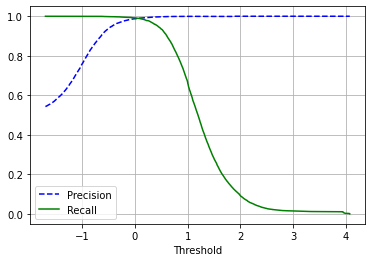

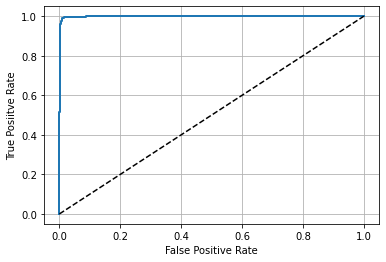

In [24]:
from sklearn.svm import SVC

## Fitting the model
svm_clf = SVC(random_state =42)
svm_clf.fit(X_train,y_train)
print(cross_val_score(svm_clf,X_train,y_train,cv=5,scoring="accuracy"))

## Predicting on the test set
svc_pred = svm_clf.predict(X_test)

## Checking accuracy metrics by function defined above
accuracy(y_test,svc_pred)

## PLotting the AUC ROC Curve and Precision vs Recall Curve
y_scores = cross_val_predict(svm_clf, X_train, y_train, cv=5,method="decision_function")
plot_prt_roc(y_train,y_scores)

#### Training the model on entire train set and saving the model

In [25]:
svm_clf.fit(train_prep,train.label)
pickle.dump(svm_clf, open('../models/svm_clf.sav', 'wb'))

### Conclusion

- From Cross Validation: Logistic Regression, Support Vector Classifier, and Stochastic Gradient Classifier give good results
- From AUC Curve: SVC and SGD show high accuracy

## Predicting on test dataset and creating submission file

In [26]:
models_to_test = [rf_clf, sgd_clf,svm_clf,log_clf] 

for model in models_to_test:
    test_pred = model.predict(test_prep)
    submit = pd.DataFrame({'id':test_id,'label':test_pred})  
    submit.to_csv(''.join(["../submissions/",str(model),".csv"]),index = False)

### Testing on Kaggle Leaderboard

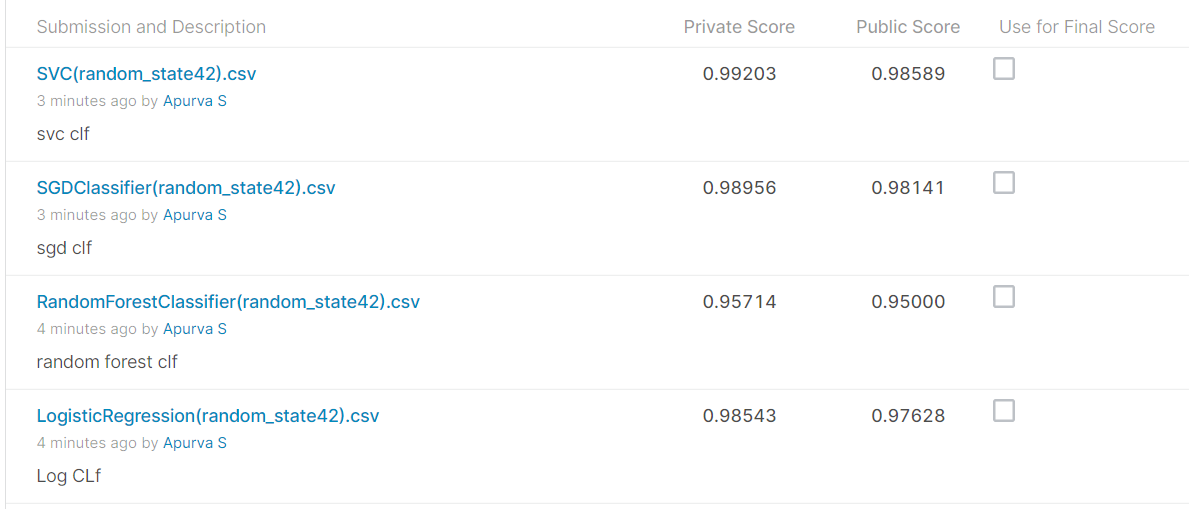